In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Set color map to have light blue background
sns.set()
import statsmodels.formula.api as smf
import statsmodels.api as sm

#Final Project by Zach Zanetti

# Predicting Real Estate Prices in Ames, Iowa.

### What is the Project?
The main purpose of this project is to build a regression model to predict the final sale price of a home in Ames, Iowa in 2010 from a set of given factors. The secondary purpose of the project is to explore and showcase the utility of data analysis/statistics tools in Python. To do these tasks I will build a multi-variate linear regression model using numpy, scipy, pandas, seaborn and statsmodels packages, and showcase the process and results in a JupyterHub Python Notebook (.ipynb). Again, the goal is prediction, as opposed to inference or trying to figure out which factors have which effects and why. The goal is simply to make the model that is the best at predicting the final result, as measured by the adjusted R-squared of the model. 



In [3]:
#read the data from CSV, note that the data is split already into a train and test set
train = pd.read_csv('train.csv')

# The Data
https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

For this project I am using data on homes in Ames, Iowa that is available for free on kaggle.com as part of a competition. The data has a train and test set. The test set does not have final sale prices and cannot be used in this project (only for the competition). Instead I will break train and test sets out of the train set for testing my model. First let's explore the dataset. The dataset is a mix of quantitative measures, such as overall quality on a scale of 1-10, living area based on square footage, lot area, etc. and categorical variables like neighborhood, Street(paved/unpaved, Pool(yes/no), etc.

The data will have to be modified for our final model. We will remove unused columns and also use a cool python trick to create categorical variables. 

In [4]:
print("The training set has the shape, ", train.shape)
#now print the head, notice the amount of NaN entries in the initial dataset
train.head(3)

The training set has the shape,  (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


You will notice that the train set has ~1460 different homes, with ~80 factors. Since there are so many factors we have a choice between a few methods to pick the best model:

* Best Subset Selection
* Forward Stepwise Selection
* Backward Stepwise Selection

We start to run into a processing power issue with any of these methods. With 80 predictors, best subset selection would have to look at $2^{80}$ combinations. In addition, both forward and backward stepwise selection would have to look at all 80 factors in the first or last round. 

Instead of starting with one of these methods, we will first try to pick out a subset of predictors through knowledge of the real estate market, then perform a forward stepwise with these narrowed down factors. To do this I reviewed the data in excel, column by column, and made a note of what I thought would be the most useful factors based on some Googling. Although prices are largely dictated by the supply chain, if we take a snapshot in time (all this data is from 2010), we should be able to predict sale prices with information like gross living space, location, quality, etc. 

Below I have narrowed down the dataset to 10 predictors, which we will experiment with when building the model. 


In [5]:
data_set = train[['SalePrice', 'OverallQual', 'LotArea', 'GrLivArea', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'Neighborhood' ]]
data_set.head(3)


,SalePrice,OverallQual,LotArea,GrLivArea,TotRmsAbvGrd,YearBuilt,YearRemodAdd,WoodDeckSF,OpenPorchSF,EnclosedPorch,Neighborhood
0,208500,7,8450,1710,8,2003,2003,0,61,0,CollgCr
1,181500,6,9600,1262,6,1976,1976,298,0,0,Veenker
2,223500,7,11250,1786,6,2001,2002,0,42,0,CollgCr


The only problem with our data now is the Neighborhood column. We need to break this out into multiple boolean columns for dummy variables i.e. each neighborhood has a yes no column. 

In [6]:
#change neighborhood to a valid categorical variable in a new dataset (not used in pairplot due to space constraints)
data_set_n = pd.get_dummies(data_set, columns = ['Neighborhood'],drop_first = True)
data_set_n.head(3)

,SalePrice,OverallQual,LotArea,GrLivArea,TotRmsAbvGrd,YearBuilt,YearRemodAdd,WoodDeckSF,OpenPorchSF,EnclosedPorch,...,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker
0,208500,7,8450,1710,8,2003,2003,0,61,0,...,0,0,0,0,0,0,0,0,0,0
1,181500,6,9600,1262,6,1976,1976,298,0,0,...,0,0,0,0,0,0,0,0,0,1
2,223500,7,11250,1786,6,2001,2002,0,42,0,...,0,0,0,0,0,0,0,0,0,0


Now that we have some working parameters, let's look at a pairplot and correlation data to search for patterns and potential issues with multicollinearity.

We should ask some of the following questions:

* Are there signs of linear relationships between certain predictors and final sale price?
* Do predictors have linear relationships with each other?
* Are there any signs of an exponential or logarithmic relationship?

               SalePrice  OverallQual   LotArea  GrLivArea  TotRmsAbvGrd  \
SalePrice       1.000000     0.790982  0.263843   0.708624      0.533723   
OverallQual     0.790982     1.000000  0.105806   0.593007      0.427452   
LotArea         0.263843     0.105806  1.000000   0.263116      0.190015   
GrLivArea       0.708624     0.593007  0.263116   1.000000      0.825489   
TotRmsAbvGrd    0.533723     0.427452  0.190015   0.825489      1.000000   
YearBuilt       0.522897     0.572323  0.014228   0.199010      0.095589   
YearRemodAdd    0.507101     0.550684  0.013788   0.287389      0.191740   
WoodDeckSF      0.324413     0.238923  0.171698   0.247433      0.165984   
OpenPorchSF     0.315856     0.308819  0.084774   0.330224      0.234192   
EnclosedPorch  -0.128578    -0.113937 -0.018340   0.009113      0.004151   

               YearBuilt  YearRemodAdd  WoodDeckSF  OpenPorchSF  EnclosedPorch  
SalePrice       0.522897      0.507101    0.324413     0.315856      -0.128578  
O

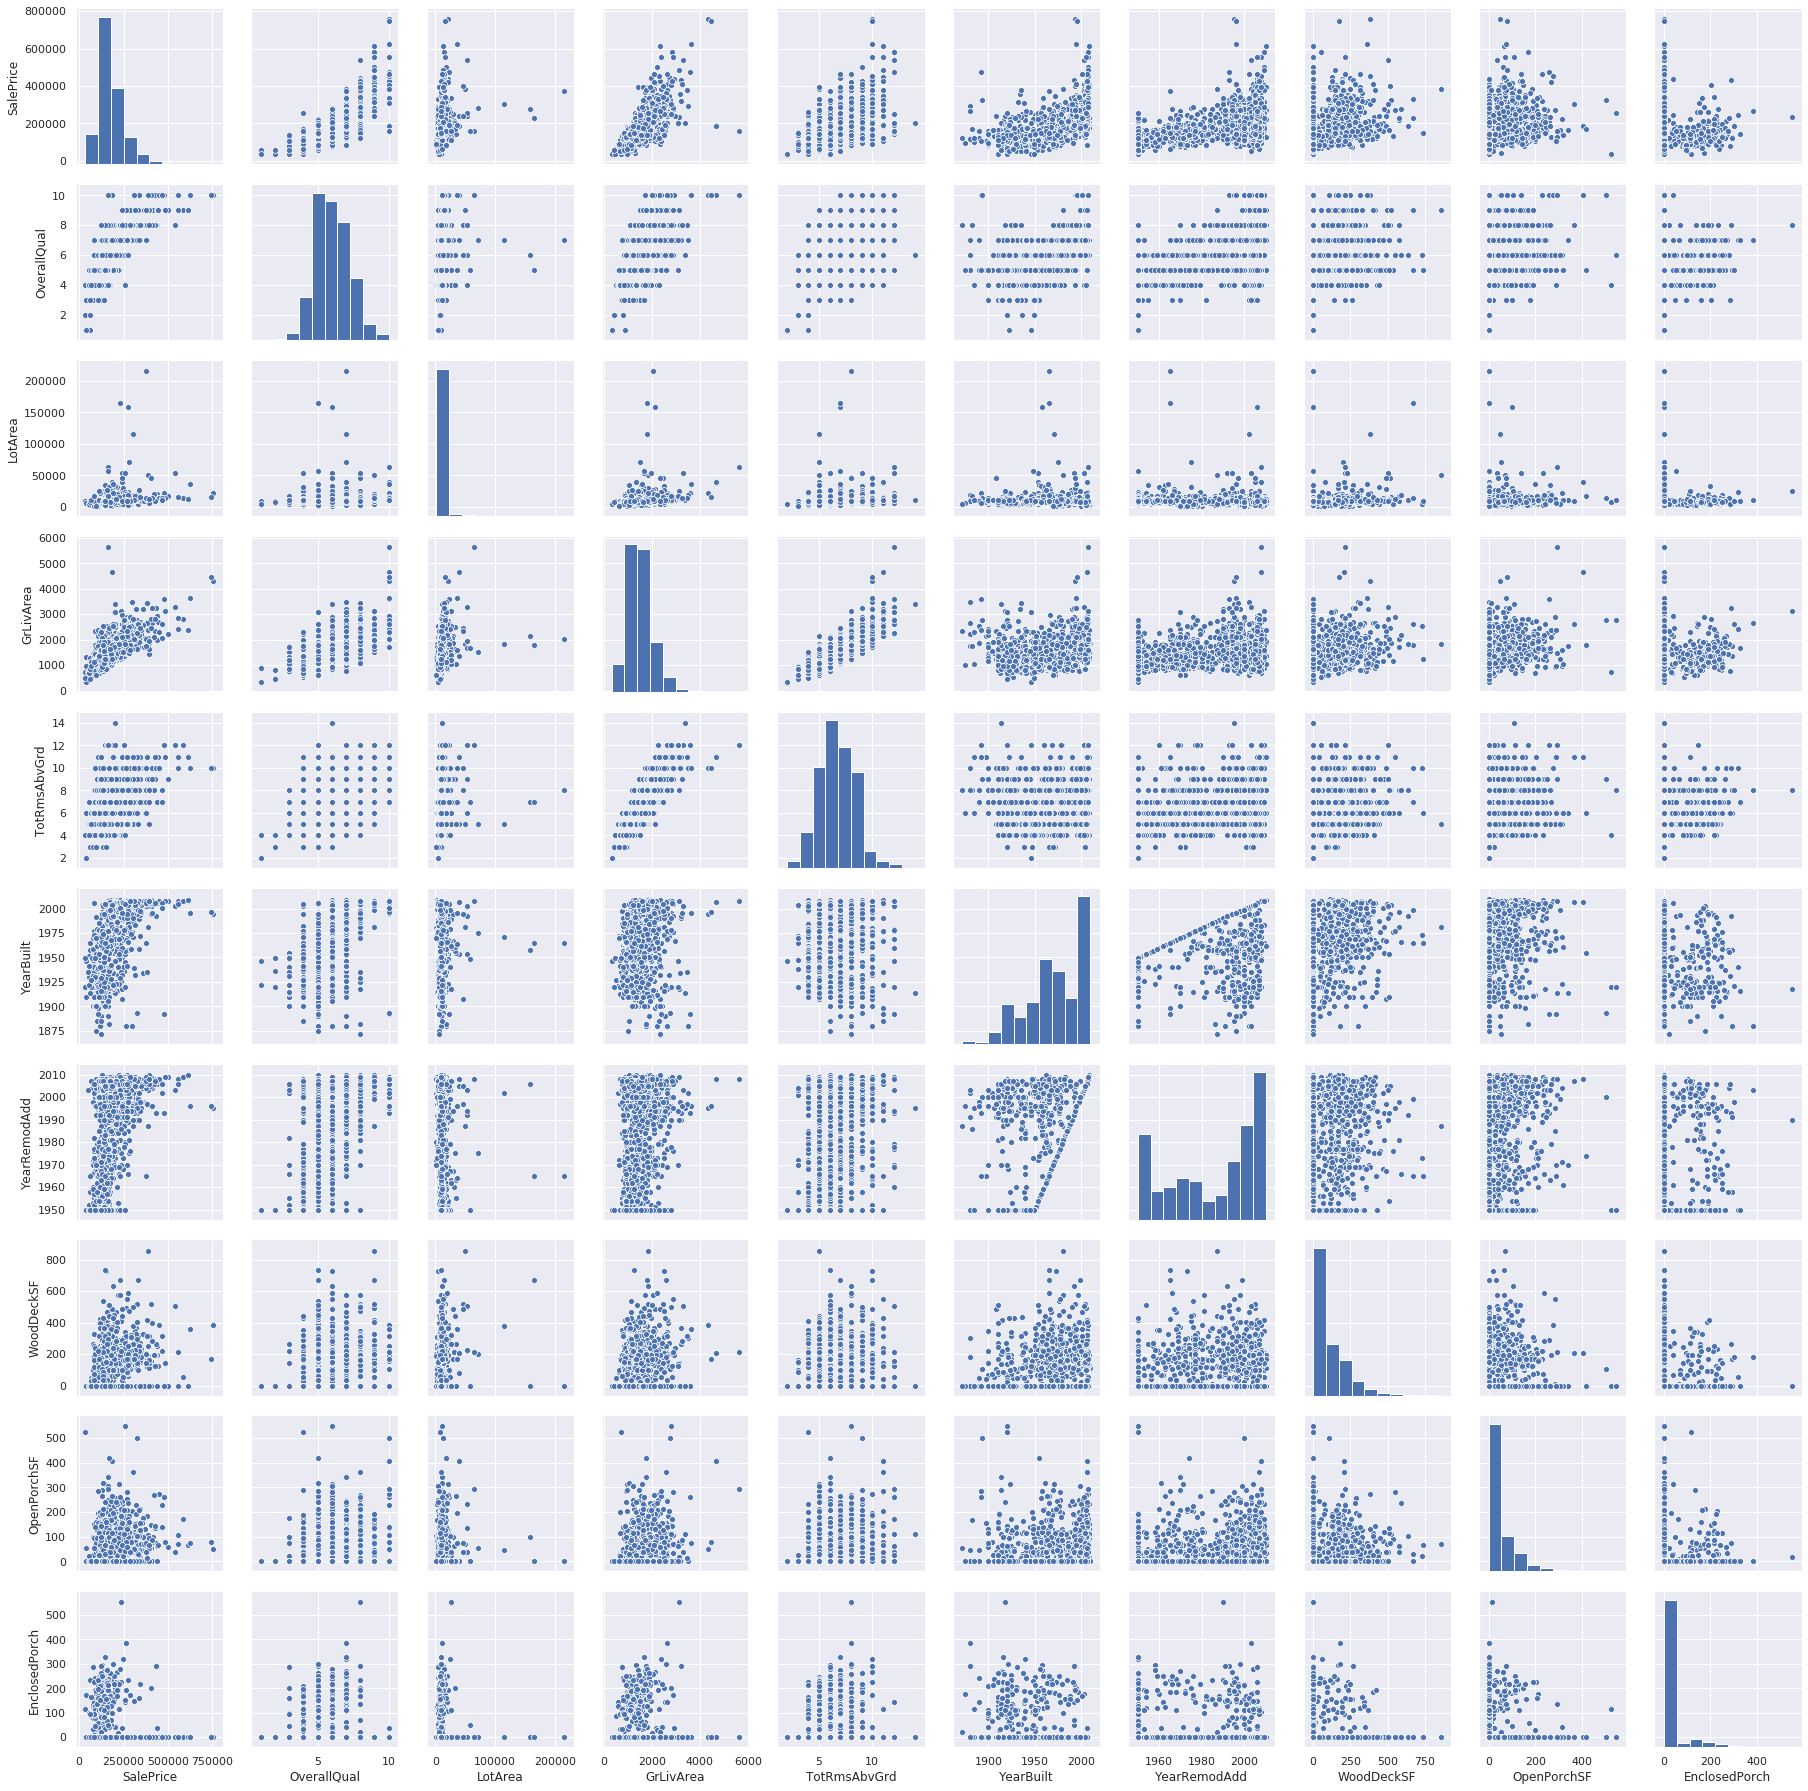

In [7]:
print(sns.pairplot(data_set))
print(data_set.corr())

Immediately we can see the factors having to do with a desk or porch have almost no relationship with saleprice. The forward stepwise selection likely will not pick these up. 

We can also see that GrLivArea and TotRmsAbvGrd are highly correlated, meaning we should consider using one of them, or both with an interaction. 

Now let's get into the model building. First let's try a model that just uses living area and neighborhood, two common predictors of price (note that the test data uses all the same neighborhoods, otherwise this would not be an option). This model should illustrate why using a forward stepwise is smarter than just trying to figure out the model based on common real estate market knowledge. 

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.692
Method:                 Least Squares   F-statistic:                     298.9
Date:                Mon, 04 May 2020   Prob (F-statistic):               0.00
Time:                        13:18:10   Log-Likelihood:                -17679.
No. Observations:                1460   AIC:                         3.538e+04
Df Residuals:                    1448   BIC:                         3.545e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             3.972e+04 

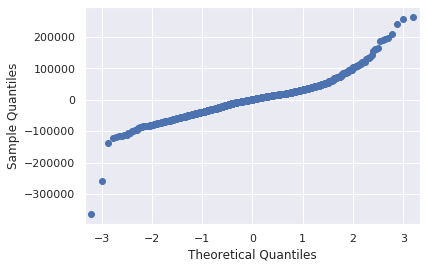

In [9]:
mod1 = smf.ols(formula='SalePrice~GrLivArea + Neighborhood_NoRidge + Neighborhood_NridgHt + Neighborhood_OldTown + Neighborhood_SWISU + Neighborhood_Sawyer + Neighborhood_SawyerW + Neighborhood_Somerst + Neighborhood_StoneBr + Neighborhood_Timber + Neighborhood_Veenker', data=data_set_n).fit()
print(mod1.summary())
sm.qqplot(mod1.resid);

Immediately we get an adjusted R-Squared of 0.692, which is not bad, however, the model seems to suffer from multicollinearity problems, likely as a result of neighborhood and living area being correlated. We can also see from the QQ plot that the sample quantiles and theoretical quantiles do not have the linear relationship we want (the curve above looks almost logarithmic).

We can also see that not every neighborhood is a significant predictor, with Sawyer and SawyerW both having a p-value above 0.05. We will drop these two and remodel below...

In [10]:
mod2 = smf.ols(formula='SalePrice~GrLivArea + Neighborhood_NoRidge + Neighborhood_NridgHt + Neighborhood_OldTown + Neighborhood_SWISU + Neighborhood_Somerst + Neighborhood_StoneBr + Neighborhood_Timber + Neighborhood_Veenker', data=data_set_n).fit()
print(mod2.summary())


                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     364.0
Date:                Mon, 04 May 2020   Prob (F-statistic):               0.00
Time:                        13:18:17   Log-Likelihood:                -17681.
No. Observations:                1460   AIC:                         3.538e+04
Df Residuals:                    1450   BIC:                         3.544e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             3.882e+04 

This model only has a slightly higher adjusted R-squared, so we clearly need a better method of building the model. Before we move on to the forward selection, take a look at the following leverage plot...

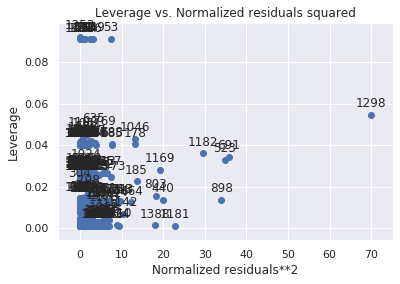

In [11]:
#Lets look at leverage to see if we have any big outliers
sm.graphics.plot_leverage_resid2(mod1, alpha=0.05);

If you look closely you will notice some outliers that are effecting the model. In order to avoid overfitting our model to this data, we will use a test and train set, both of size n=200, to perform the forward stepwise selection. Note that if you are running the Jupyter Notebook you can experiment with the model by changing n (up to 1460).

## Now lets start a forward stepwise selection from scratch...

In [24]:
#create a list of allowed factors from the 80 starting parameters, note that this includes neighborhood booleans.
allowed_factors = ['OverallQual', 'LotArea', 'GrLivArea', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'Neighborhood_NoRidge',  'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker']

In [25]:
#Variable in case we want to try with a bigger train/test set
n = 200

#Store the starting length of allowed_factors
length_af = len(allowed_factors)


#first need to select 200 indexes with replacement
set_train_i = np.random.choice(data_set_n.index, n, replace=True)
set_test_i = np.random.choice(data_set_n.index, n, replace=True)

#then need to use only data with selected indexes to build model sets 
set_train = data_set_n.loc[set_train_i]
set_test = data_set_n.loc[set_test_i]

#error checking, play the previous box on error
assert len(set_train.index) == n, "something went wrong"
assert len(set_train.index) == n, "something went wrong"

Now pick the first winner based on adjusted R-Squared, note that I could have used a recursive function to build a forward model up to m parameters, however, the step by step is better for learning purposes. 

In [26]:
winner = (0, 'N/A')
assert len(allowed_factors) == length_af
best = 0

for factor in allowed_factors:
    y = set_train.SalePrice
    X = set_train.loc[:, factor]
    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    results_1 = model.fit()

    r2 = results_1.rsquared_adj
    
    if r2 >= best:
        best = r2
        winner = factor
    
print("The first winner is ", winner, "with an adj. R-squared of ", best)
Rsquared_adj_1 = best


/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


The first winner is  OverallQual with an adj. R-squared of  0.6638865209580378


The winner is typically OverallQual.

Continue to the second factor...

In [27]:
try:
    allowed_factors.remove(winner)
except:
    exit

best = 0

for factor in allowed_factors:
    y = set_train.SalePrice
    df = set_train.loc[:, (factor, winner)]
    X = sm.add_constant(df)
    model = sm.OLS(y, X)
    results_2 = model.fit()
    r2 = results_2.rsquared_adj
    
    if r2 >= best:
        best = r2
        winner2 = factor
    
print("The winner is ", winner2, "with an adj. R-squared of ", best)
Rsquared_adj_2 = best

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


The winner is  Neighborhood_NridgHt with an adj. R-squared of  0.6995474148709706


The winner is typically GrLivArea

Continue to the third factor....

In [28]:
try:
    allowed_factors.remove(winner2)
except:
    exit

best = 0

for factor in allowed_factors:
    y = set_train.SalePrice
    df = set_train.loc[:, (factor, winner, winner2)]
    X = sm.add_constant(df)
    model = sm.OLS(y, X)
    results_3 = model.fit()
    r2 = results_3.rsquared_adj
    
    if r2 >= best:
        best = r2
        winner3 = factor
    
print("The winner is ", winner3, "with an adj. R-squared of ", best)
Rsquared_adj_3 = best

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


The winner is  GrLivArea with an adj. R-squared of  0.7321633623705045


The winner is typically Neighborhood_StoneBr or Neighborhood_NridgHt

Continue to the fourth factor....

In [29]:
try:
    allowed_factors.remove(winner3)
except:
    exit

best = 0

for factor in allowed_factors:
    y = set_train.SalePrice
    df = set_train.loc[:, (factor, winner, winner2, winner3)]
    X = sm.add_constant(df)
    model = sm.OLS(y, X)
    results_4 = model.fit()
    r2 = results_4.rsquared_adj
    
    if r2 >= best:
        best = r2
        winner4 = factor
    
print("The winner is ", winner4, "with an adj. R-squared of ", best)
Rsquared_adj_4 = best

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


The winner is  YearRemodAdd with an adj. R-squared of  0.7432789557638119


The winner is typically Neighborhood_StoneBr

Continue to the fifth factor....


In [30]:
try:
    allowed_factors.remove(winner4)
except:
    exit

best = 0

for factor in allowed_factors:
    y = set_train.SalePrice
    df = set_train.loc[:, (factor, winner, winner2, winner3, winner4)]
    X = sm.add_constant(df)
    model = sm.OLS(y, X)
    results_5 = model.fit()
    r2 = results_5.rsquared_adj
    
    if r2 >= best:
        best = r2
        winner5 = factor
    
print("The winner is ", winner5, "with an adj. R-squared of ", best)
Rsquared_adj_5 = best

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


The winner is  WoodDeckSF with an adj. R-squared of  0.7506682319445088


Continue to the sixth factor....


In [31]:
try:
    allowed_factors.remove(winner5)
except:
    exit

best = 0

for factor in allowed_factors:
    y = set_train.SalePrice
    df = set_train.loc[:, (factor, winner, winner2, winner3, winner4, winner5)]
    X = sm.add_constant(df)
    model = sm.OLS(y, X)
    results_6 = model.fit()
    r2 = results_6.rsquared_adj
    
    if r2 >= best:
        best = r2
        winner6 = factor
    
print("The winner is ", winner6, "with an adj. R-squared of ", best)
Rsquared_adj_6 = best

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


The winner is  Neighborhood_OldTown with an adj. R-squared of  0.7556905684682876


Continue to the seventh factor....

In [32]:
try:
    allowed_factors.remove(winner6)
except:
    exit

best = 0

for factor in allowed_factors:
    y = set_train.SalePrice
    df = set_train.loc[:, (factor, winner, winner2, winner3, winner4, winner5, winner6)]
    X = sm.add_constant(df)
    model = sm.OLS(y, X)
    results_7 = model.fit()
    r2 = results_7.rsquared_adj
    
    if r2 >= best:
        best = r2
        winner7 = factor
    
print("The winner is ", winner7, "with an adj. R-squared of ", best)
Rsquared_adj_7 = best

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


The winner is  Neighborhood_StoneBr with an adj. R-squared of  0.7604733312947667


Lastly, try the eighth factor...

In [33]:
try:
    allowed_factors.remove(winner7)
except:
    exit

best = 0

for factor in allowed_factors:
    y = set_train.SalePrice
    df = set_train.loc[:, (factor, winner, winner2, winner3, winner4, winner5, winner6, winner7)]
    X = sm.add_constant(df)
    model = sm.OLS(y, X)
    results_8 = model.fit()
    r2 = results_8.rsquared_adj
    
    if r2 >= best:
        best = r2
        winner8 = factor
    
print("The winner is ", winner8, "with an adj. R-squared of ", best)
Rsquared_adj_8 = best

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


The winner is  Neighborhood_NoRidge with an adj. R-squared of  0.7638278630853813


In [35]:
results_8.summary()
#typically you should see all p values under 0.05, if not, rerun the model.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     91.26
Date:                Mon, 04 May 2020   Prob (F-statistic):           1.25e-57
Time:                        13:22:10   Log-Likelihood:                -2386.9
No. Observations:                 200   AIC:                             4790.
Df Residuals:                     192   BIC:                             4816.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -9.977e+05   3.24e+05     -3.083      0.002   -1.64e+06   -3.59e+05
Neighborhood_Veenker  2.228e-07   7.23e-08      3.083      0.002    8.03e-08    3.65e-07
OverallQual           2.332e+04   2947.215      7.912      0.000    1.75e+04    2.91e+04
Neighborhood_NridgHt  5.768e+04   1.01e+04      5.710      0.000    3.78e+04    7.76e+04
GrLivArea               30.5393      5.897      5.179      0.000      18.908      42.170
YearRemodAdd           492.3238    166.814      2.951      0.004     163.301     821.346
WoodDeckSF              58.7453     22.460      2.616      0.010      14.446     103.045
Neighborhood_OldTown -2.196e+04   9702.219     -2.263      0.025   -4.11e+04   -2823.097
Neighborhood_StoneBr  4.343e+04   1.97e+04      2.203      0.029    4548.691    8.23e+04
==============================================================================
Omnibus:                       78.879   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              884.164
Skew:                          -1.133   Prob(JB):                    1.01e-192
Kurtosis:                      13.048   Cond. No.                     8.73e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.69e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

 ### Now lets plot the adjusted R-Squared vs the number of predictors for the train and test data.

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


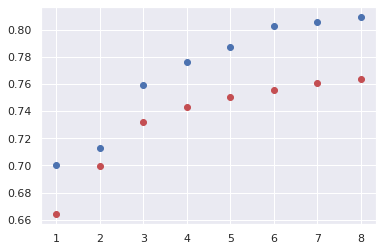

In [36]:
predictors = np.array([1, 2, 3, 4, 5, 6, 7, 8])
AR2 = np.array([Rsquared_adj_1, Rsquared_adj_2, Rsquared_adj_3, Rsquared_adj_4, Rsquared_adj_5, Rsquared_adj_6, Rsquared_adj_7, Rsquared_adj_8])

plt.plot(predictors, AR2, 'ro')



y = set_test.SalePrice
df = set_test.loc[:, winner]
X = sm.add_constant(df)
model = sm.OLS(y, X)
results1 = model.fit()
rat1 = results1.rsquared_adj

y = set_test.SalePrice
df = set_test.loc[:, (winner, winner2)]
X = sm.add_constant(df)
model = sm.OLS(y, X)
results2 = model.fit()
rat2 = results2.rsquared_adj

y = set_test.SalePrice
df = set_test.loc[:, (winner, winner2, winner3)]
X = sm.add_constant(df)
model = sm.OLS(y, X)
results3 = model.fit()
rat3 = results3.rsquared_adj

y = set_test.SalePrice
df = set_test.loc[:, (winner, winner2, winner3, winner4)]
X = sm.add_constant(df)
model = sm.OLS(y, X)
results4 = model.fit()
rat4 = results4.rsquared_adj

y = set_test.SalePrice
df = set_test.loc[:, (winner, winner2, winner3, winner4, winner5)]
X = sm.add_constant(df)
model = sm.OLS(y, X)
results5 = model.fit()
rat5 = results5.rsquared_adj

y = set_test.SalePrice
df = set_test.loc[:, (winner, winner2, winner3, winner4, winner5, winner6)]
X = sm.add_constant(df)
model = sm.OLS(y, X)
results6 = model.fit()
rat6 = results6.rsquared_adj

y = set_test.SalePrice
df = set_test.loc[:, (winner, winner2, winner3, winner4, winner5, winner6, winner7)]
X = sm.add_constant(df)
model = sm.OLS(y, X)
results7 = model.fit()
rat7 = results7.rsquared_adj

y = set_test.SalePrice
df = set_test.loc[:, (winner, winner2, winner3, winner4, winner5, winner6, winner7, winner8)]
X = sm.add_constant(df)
model = sm.OLS(y, X)
results8 = model.fit()
rat8 = results8.rsquared_adj



ARt2 = np.array([rat1, rat2, rat3, rat4, rat5, rat6, rat7, rat8])
plt.plot(predictors, ARt2, 'bo')

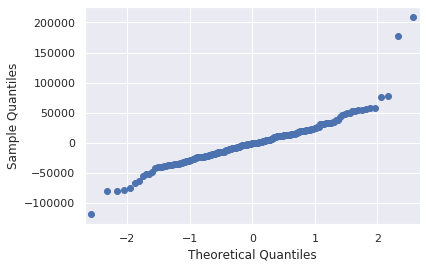

In [61]:
sm.qqplot(results8.resid);

### The final model

I showed forward stepwise up to 8 predictors. I noticed that while there were incremental increased in the adjusted r-squared of the training data after 8, the adjusted r-squared of the test data levels off around 8 factors. I chose to stick with 8 factors for my final model. 

In [37]:
print('The final model uses the predictors ', winner, winner2, winner3, winner4, winner5, winner6, winner7, 'and', winner8)

The final model uses the predictors  OverallQual Neighborhood_NridgHt GrLivArea YearRemodAdd WoodDeckSF Neighborhood_OldTown Neighborhood_StoneBr and Neighborhood_NoRidge


In [39]:
final_data = data_set_n[[winner, winner2, winner3, winner4, winner5, winner6, winner7, winner8]]
#Notice that OverallQual is correlated with GrLivArea and YearRemodAdd. Further exploration of the data might involve looking at interactions between these, 
#or removing one of the factors to deal with collinearity. 
print(sns.pairplot(final_data))
print(final_data.corr())

                      OverallQual  Neighborhood_NridgHt  GrLivArea  \
OverallQual              1.000000              0.368724   0.593007   
Neighborhood_NridgHt     0.368724              1.000000   0.179892   
GrLivArea                0.593007              0.179892   1.000000   
YearRemodAdd             0.550684              0.243558   0.287389   
WoodDeckSF               0.238923              0.108203   0.247433   
Neighborhood_OldTown    -0.148731             -0.068342  -0.019705   
Neighborhood_StoneBr     0.196736             -0.031144   0.091365   
Neighborhood_NoRidge     0.224693             -0.040108   0.321450   

                      YearRemodAdd  WoodDeckSF  Neighborhood_OldTown  \
OverallQual               0.550684    0.238923             -0.148731   
Neighborhood_NridgHt      0.243558    0.108203             -0.068342   
GrLivArea                 0.287389    0.247433             -0.019705   
YearRemodAdd              1.000000    0.205726             -0.132494   
WoodDeckS

# Why is a model that predicts real estate prices useful?

The reason a model that predicts prices based on factors about a home is useful is because people looking to buy or sell want to know they are settling at the correct market price. Buyer's and Seller's both have trouble figuring out the correct price to list a home or make an offer on a home. If a seller lists a house too high, they might not sell it in a reasonable amount of time, while if they list it too low, they are missing out on profit. A buyer that bids too low will typically lose a house, while a buyer that bids too high is wasting money. 


Some research reveals that housing prices have a lot to do with factors outside of the house itself, like market supply (https://medium.com/swlh/predicting-the-housing-market-is-easier-than-you-think-45239a366dc1). So some people might wonder, if we dont use information on supply, is our model useful?


The answer is yes, you could quickly train a model on data from the last 6 months of sales if you had access, and use it to get a good market price estimate on a house for sale. 

With a final adjusted R-squared near .8 for the test data, the model has a reasonable amount of predictive power compared to prediction using the mean, or prediction using neighborhood and living area (recall this adj. r-squared was around .6).